# Sentiment Analysis Poltik Indonesia

# Model Training & Evaluation
Model yang digunakan untuk training dataset hasil dari TF-IDF adalah traditional mechine learning <br>
karena dataset yang dimiliki relatif kecil

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from collections import Counter   # Untuk menghitung frekuensi kata
from wordcloud import WordCloud   

In [2]:
# Load Dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('./tweet_preprocess_tfidf.csv')
df.head()

,sentimen,tweet,tweet_tokenized,tweet_no_stopwords,tweet_stemmed,tweet_process
0,negatif,kata indonesia tidak dihargai bangsa asing ...,"['kata', '@', 'prabowo', 'indonesia', 'tidak',...","['@', 'prabowo', 'indonesia', 'dihargai', 'ban...","['', 'prabowo', 'indonesia', 'harga', 'bangsa'...",prabowo indonesia harga bangsa asing berita ...
1,netral,batuan langka tasbih jokowi hadiah dari habib ...,"['batuan', 'langka', ',', 'tasbih', 'jokowi', ...","['batuan', 'langka', ',', 'tasbih', 'jokowi', ...","['batu', 'langka', '', 'tasbih', 'jokowi', 'ha...",batu langka tasbih jokowi hadiah habib luthfi...
2,netral,di era jokowi ekonomi indonesia semakin baik i...,"['di', 'era', 'jokowi', ',', 'ekonomi', 'indon...","['era', 'jokowi', ',', 'ekonomi', 'indonesia',...","['era', 'jokowi', '', 'ekonomi', 'indonesia', ...",era jokowi ekonomi indonesia 01indonesiamaj...
3,positif,bagi sumatera selatan asian games berdampak pd...,"['bagi', 'sumatera', 'selatan', ',', 'asian', ...","['sumatera', 'selatan', ',', 'asian', 'games',...","['sumatera', 'selatan', '', 'asi', 'games', 'd...",sumatera selatan asi games dampak pd ekonomi ...
4,negatif,negara kita ngutang buat bngun infrastruktur y...,"['negara', 'kita', 'ngutang', 'buat', 'bngun',...","['negara', 'ngutang', 'bngun', 'infrastruktur'...","['negara', 'ngutang', 'bngun', 'infrastruktur'...",negara ngutang bngun infrastruktur udah dipake...


In [3]:
# Buat variabel label fitur dan target
X_text = df['tweet_process'].fillna('')
y = df['sentimen']

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(X_text)
print('Shape TF-IDF matrix:', X.shape)

Shape TF-IDF matrix: (1815, 3000)


In [4]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Jumlah data train : ', X_train.shape[0])
print('Jumlah data test : ', X_test.shape[0])

Jumlah data train :  1452
Jumlah data test :  363


## Training model 

### Traditional Mechine Learning

#### Logistic Regression

In [5]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred)
print("Akurasi :", accuracy_score(y_test, y_pred))
print("Hasil Evaluasi :\n", classification_report(y_test, y_pred))

Akurasi : 0.6253443526170799
Hasil Evaluasi :
               precision    recall  f1-score   support

     negatif       0.63      0.73      0.68       117
      netral       0.65      0.53      0.58       127
     positif       0.60      0.63      0.61       119

    accuracy                           0.63       363
   macro avg       0.63      0.63      0.62       363
weighted avg       0.63      0.63      0.62       363



In [6]:
# Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['lbfgs', 'liblinear'], 
    'penalty': ['l2'],
    'class_weight': ['balanced', None]
    }
grid = GridSearchCV(LogisticRegression(max_iter=3000),
                    param_grid, cv=5,
                    scoring='accuracy')
grid.fit(X_train, y_train)
print("Parameter terbaik:", grid.best_params_)
print("Akurasi terbaik:", grid.best_score_)
best_acc_lr = grid.best_score_

Parameter terbaik: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Akurasi terbaik: 0.6322336769759451


#### Random Forest

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", acc_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 0.5537190082644629
Random Forest Classification Report:
               precision    recall  f1-score   support

     negatif       0.54      0.68      0.60       117
      netral       0.58      0.46      0.51       127
     positif       0.55      0.54      0.54       119

    accuracy                           0.55       363
   macro avg       0.56      0.56      0.55       363
weighted avg       0.56      0.55      0.55       363



#### Support Vector Machine (SVM)

In [8]:
svm_model = SVC(kernel='linear', random_state=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", acc_svm)
print("SVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Accuracy: 0.6143250688705234
SVM Classification Report:
               precision    recall  f1-score   support

     negatif       0.59      0.76      0.67       117
      netral       0.68      0.49      0.57       127
     positif       0.59      0.61      0.60       119

    accuracy                           0.61       363
   macro avg       0.62      0.62      0.61       363
weighted avg       0.62      0.61      0.61       363



### Deep Learning

#### Naive Bayes

In [9]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy:", acc_nb)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.6198347107438017
Naive Bayes Classification Report:
               precision    recall  f1-score   support

     negatif       0.68      0.70      0.69       117
      netral       0.66      0.47      0.55       127
     positif       0.55      0.70      0.61       119

    accuracy                           0.62       363
   macro avg       0.63      0.62      0.62       363
weighted avg       0.63      0.62      0.62       363



#### Convolutional Neural Network (CNN)

In [10]:
# Prepare text and labels
X_text = df['tweet_process'].fillna('')
y = df['sentimen']

# Encode labels to integers
label_mapping = {label: idx for idx, label in enumerate(sorted(y.unique()))}
y_encoded = y.map(label_mapping)

# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)

# Pad sequences
X_pad = pad_sequences(X_seq, maxlen=100, padding='post', truncating='post')

# One-hot encode labels
y_cat = to_categorical(y_encoded)

# Split data ulang
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=1)

# CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(5000, 100, input_length=100))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(y_cat.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Latih model
cnn_model = create_cnn_model()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=2)
loss, acc_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Accuracy: {acc_cnn:.4f}")

Epoch 1/10


C:\Users\SUWAAAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 - 1s - 36ms/step - accuracy: 0.3816 - loss: 1.0898 - val_accuracy: 0.5155 - val_loss: 1.0701
Epoch 2/10
37/37 - 0s - 6ms/step - accuracy: 0.6184 - loss: 0.9941 - val_accuracy: 0.5189 - val_loss: 1.0192
Epoch 3/10
37/37 - 0s - 7ms/step - accuracy: 0.7382 - loss: 0.8605 - val_accuracy: 0.5911 - val_loss: 0.9616
Epoch 4/10
37/37 - 0s - 7ms/step - accuracy: 0.8105 - loss: 0.6880 - val_accuracy: 0.5876 - val_loss: 0.9179
Epoch 5/10
37/37 - 0s - 7ms/step - accuracy: 0.8872 - loss: 0.4944 - val_accuracy: 0.5911 - val_loss: 0.9147
Epoch 6/10
37/37 - 0s - 7ms/step - accuracy: 0.9380 - loss: 0.3251 - val_accuracy: 0.5876 - val_loss: 0.9412
Epoch 7/10
37/37 - 0s - 8ms/step - accuracy: 0.9673 - loss: 0.1988 - val_accuracy: 0.5739 - val_loss: 1.0076
Epoch 8/10
37/37 - 0s - 9ms/step - accuracy: 0.9681 - loss: 0.1367 - val_accuracy: 0.6048 - val_loss: 1.0863
CNN Test Accuracy: 0.5978


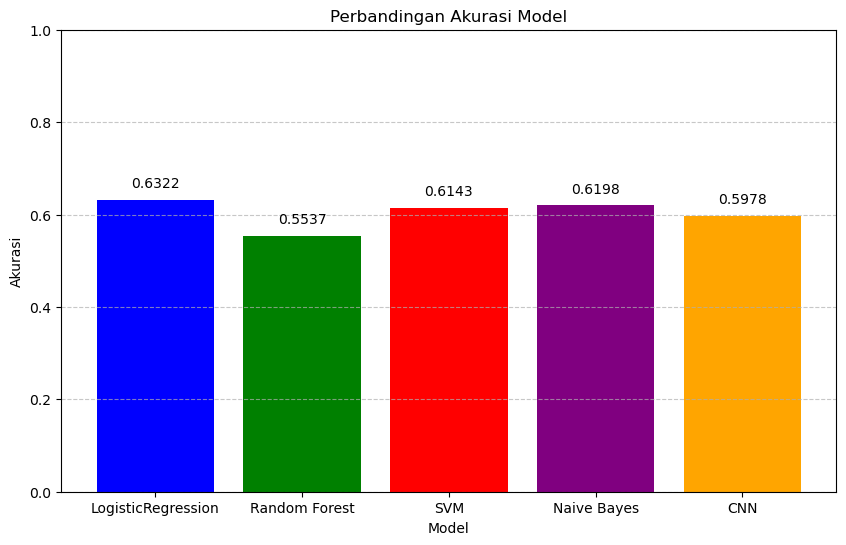

In [11]:
# Visualisasi perbandingan akurasi model
model_names = ['LogisticRegression', 'Random Forest', 'SVM', 'Naive Bayes', 'CNN']
accuracies = [best_acc_lr, acc_rf, acc_svm, acc_nb, acc_cnn]

plt.figure(figsize=(10,6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylim([0, 1])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

- coba algoritma lain
- count factorizer (binary)
- coba tweet tokenizer
- coba bandingan data yang ada isi dan tanpa hastag
- maksimal 0.70 sekarang
- lihat score klasifikasi, identifikasi kenapa ada score yang kecil 
- cek untuk deep learning
- tweet_process itu kan digabungkan jadi 1 kalimat, coba untuk tetap di split per kata untuk lihat akurasinya


## Visualisasi Hasil

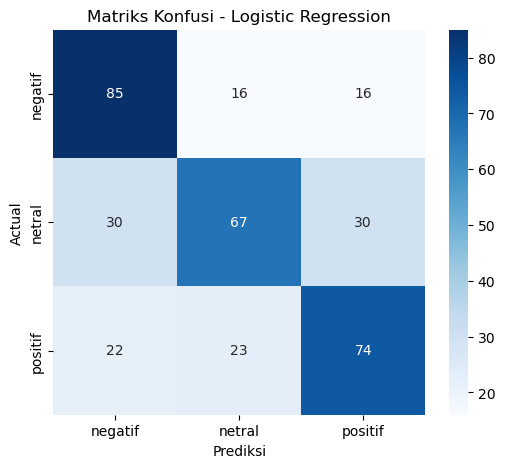

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data
labels = ['negatif', 'netral', 'positif']
value = [117, 127, 119]

# TP berdasarkan recall * value
recall = [0.73, 0.53, 0.63]

# bulatkan hasil recall ke INT tidak decimal
# TP
true_positif = [int(r * v) for r, v in zip(recall, value)]

# FP
false_negatif = [v - tp for v, tp in zip(value, true_positif)]

#  matriks konfusi
conf_matrix = np.zeros((3, 3), dtype=int)  # buat matriks 3x3
conf_matrix[0, 0], conf_matrix[1, 1], conf_matrix[2, 2] = true_positif  # isi kolom [(1,1), (2,2), (3,3)] dengan nilai TP
conf_matrix[0, 1], conf_matrix[0, 2] = false_negatif[0] // 2, false_negatif[0] - false_negatif[0] // 2  # negatif
conf_matrix[1, 0], conf_matrix[1, 2] = false_negatif[1] // 2, false_negatif[1] - false_negatif[1] // 2  # netral
conf_matrix[2, 0], conf_matrix[2, 1] = false_negatif[2] // 2, false_negatif[2] - false_negatif[2] // 2  # positif

# Visualisasi heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriks Konfusi - Logistic Regression')
plt.xlabel('Prediksi')
plt.ylabel('Actual')
plt.show()

10 Kata Paling Sering Muncul :
ekonomi: 1043
jokowi: 917
prabowo: 746
yg: 666
gaji: 548
com: 432
harga: 428
https: 370
presiden: 361
indonesia: 320


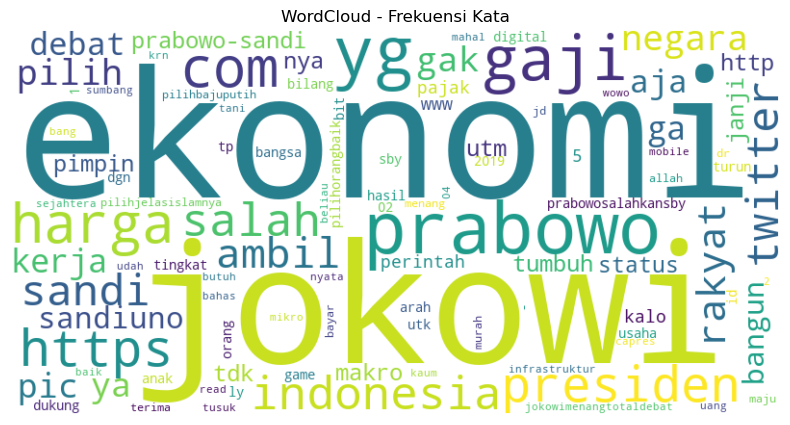

In [13]:
# Gabungkan semua teks di kolom 'tweet_process'
all_text = ' '.join(df['tweet_process'].dropna())

# Hitung frekuensi kata
words = all_text.split()
word_freq = Counter(words)

# Tampilkan 10 kata paling sering muncul
print("10 Kata Paling Sering Muncul :")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

# Buat WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      max_words=100, colormap='viridis').generate_from_frequencies(word_freq)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Frekuensi Kata')
plt.show()


Rata-rata jumlah tweet per sentimen
sentimen
netral     17.60
negatif    19.85
positif    20.09
Name: word_count, dtype: float64


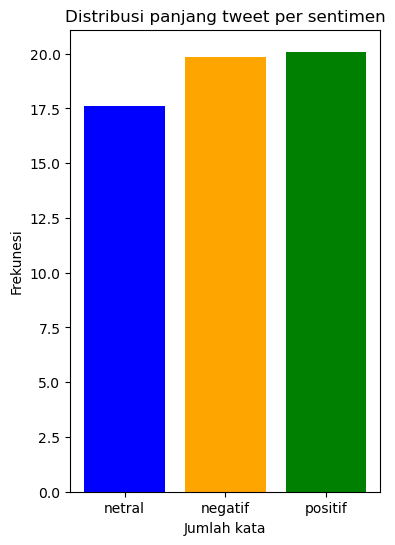

In [14]:
# Buat kolom baru untuk hitung jumlah kata dari setiap target tweet
df['word_count'] = df['tweet_process'].dropna().apply(lambda x: len(x.split()))

avg_wordcount = df.groupby('sentimen')['word_count'].mean().round(2).sort_values(ascending=True)

print("Rata-rata jumlah tweet per sentimen")
print(avg_wordcount)

# Buat barchart
plt.figure(figsize=(4, 6))
plt.bar (avg_wordcount.index, avg_wordcount.values, color=['blue', 'orange', 'green'])
plt.title('Distribusi panjang tweet per sentimen')
plt.xlabel('Jumlah kata')
plt.ylabel('Frekunesi')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

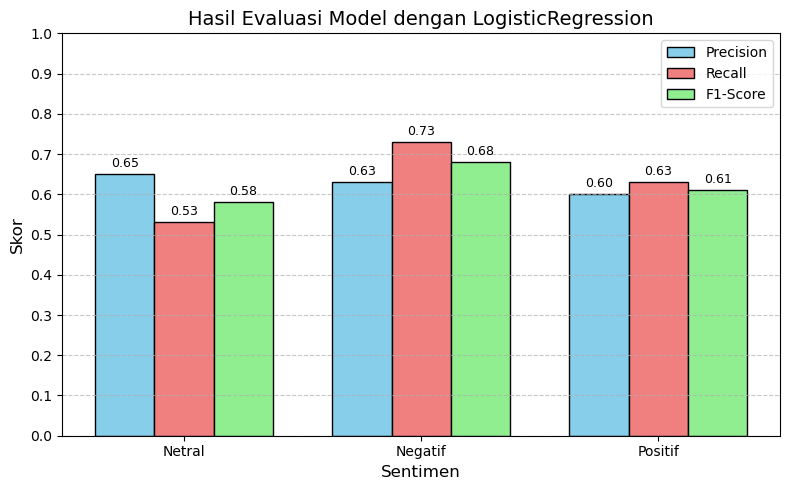

In [15]:
# Data hasil LogisticRegression
sentimen = ['Netral', 'Negatif', 'Positif']
precision = [0.65, 0.63, 0.60]
recall = [0.53, 0.73, 0.63]
f1_score = [0.58, 0.68, 0.61]

# Setup untuk bar chart
x = np.arange(len(sentimen))
width = 0.25

# Buat figure dan axes
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))

# Buat bar chart
bar1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue', edgecolor='black')
bar2 = ax.bar(x, recall, width, label='Recall', color='lightcoral', edgecolor='black')
bar3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='lightgreen', edgecolor='black')

# Tambah label dan judul
ax.set_xlabel('Sentimen', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('Hasil Evaluasi Model dengan LogisticRegression', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(sentimen, fontsize=10)

# Tambah value di bar
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=9)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.legend(fontsize=10)
plt.tight_layout()

plt.show()

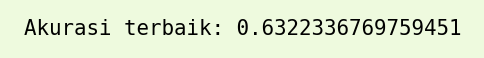

In [16]:
def print_text(text):
    fig, ax = plt.subplots(figsize=(6, 0.5), facecolor="#eefade")
    ax.text(0.5, 0.5, text, ha='center', va='center', size=15)
    ax.axis("off")
    plt.show()


plt.rcParams["font.family"] = "monospace"
print_text('Akurasi terbaik: 0.6322336769759451')